# Analysis Summary

This notebook provides answers to questions about the open-coding analysis process itself.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

Import all codes from the open coding process

In [2]:
%%time
codes = getCodes()

CPU times: user 32.7 s, sys: 80 ms, total: 32.7 s
Wall time: 33 s


Parse works cited section of the `README.md` document for more analysis information.

In [3]:
# See regular expression at regexr.com/4htcn
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([\w\d\s]+)\*\.\sRetrieved from (.*)\n'
with open('README.md') as readme:
    content = readme.read();

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'url'])
citations.head()

,journalist,year,month,date,article,organization,url
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,https://github.com/BuzzFeedNews/2016-09-shy-tr...
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,https://github.com/fivethirtyeight/data
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Forbes,https://github.com/voxmedia/data-projects
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,https://github.com/BBC-Data-Unit/electric-car-...
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,https://github.com/BBC-Data-Unit/internal-migr...


Also get the list of data journalism repos identified in `find_notebooks.ipynb`. 

In [4]:
repos = pd.read_csv('potential_notebooks.csv')
keepers = repos[repos.is_keeper == True]

## Analysis by the numbers

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,21
organization,17
article,34
codes,154
repos,1295
relevant repos,225
total organizations,50


## Progress towards convergence

In [6]:
codingOrder = pd.DataFrame({'article': [
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'cube_root_law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat_and_humidity',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-cc-score-analysis',
    '2019-04-democratic-candidate-codonors',
    'california-ccscore-analysis'
][::-1] }).reset_index().rename(columns={'index': 'coding order'})

Create a data frame of codes grouped by article.

In [7]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0
#codesByArticle['cumulative codeset'] = None

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,13,california-ccscore-analysis,"[format table display, read as tabular data, d...",0,23,"calculate z-score, adjust for season, drop col..."
1,6,2019-04-democratic-candidate-codonors,"[use public data, read as tabular data, archit...",1,42,"self join table, union tables, change case, ca..."
2,14,california-crop-production-wages-analysis,"[use public data, format table display, constr...",3,45,"construct table manually, architect repeating ..."
3,16,census-hard-to-map-analysis,"[wrangle data for graphics, use public data, c...",4,47,"slice column values, wrangle data for graphics"
4,25,long-term-care-db,"[count value frequency, calculate scaled ratio...",5,56,"drop erroneous rows, construct pivot table, en..."


Plot the size of the code set as more computational notebooks are analyzed.

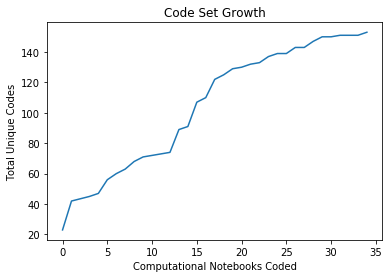

In [8]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

Map codes back to the article where they were introduced to the code set.

In [9]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **california-ccscore-analysis**: calculate z-score, adjust for season, drop columns, inspect table schema, calculate mean, count number of records, calculate percentage difference, peek at data, split, compute, and merge, inner join tables, sort table, drop entirely duplicate rows, remove incomplete data, calculate difference, export results, change column data type, repetitive code, format table display, read as tabular data, filter rows, count value frequency, plot histogram, group by single column

2. **2019-04-democratic-candidate-codonors**: self join table, union tables, change case, canonicalize column names, sum column values, export intermediate results, gather table, strip whitespace, use public data, prevent double-counting, group by multiple columns, architect a subroutine, calculate ratio, annotate workflow, count unique values in column, outer join tables, calculate scaled ratio, remove with regular expression, create a semi-unique key

3. **california-crop-production-wages-analysis**: construct table manually, architect repeating process, adjust for inflation

4. **census-hard-to-map-analysis**: slice column values, wrangle data for graphics

5. **long-term-care-db**: drop erroneous rows, construct pivot table, encode table identification in row, use non-public, provided data, join with lookup table, scrape web for data, perform name entity resolution manually, drop rows with duplicate value in one column, fix data errors manually

6. **2018-voter-registration**: plot stacked column chart, plot stacked bar chart, extract single value, pull tables out of pdf

7. **heat_and_humidity**: generate data computationally, cartesian product, compute index number

8. **2016-11-bellwether-counties**: create rolling window, get max value, use academic data, spread table, calculate spread

9. **2018-05-31-crime-and-heat-analysis**: combine seemingly disparate datasets, plot scatterplot, extract property from datetime

10. **2016-09-shy-trumpers**: use another news orgs data

11. **cube_root_law**: calculate using an external data structure

12. **2016-04-republican-donor-movements**: split column on delimiter

13. **california-h2a-visas-analysis**: remove all rows but the master record, preserve existing values, split and compute, temporary joining column, encoding provenance in data, plot column chart, cache results from external service, display entire table, trim by geographic area, create a unique key, replace na values, create a crosstab, geocode addresses, omits data quality exploration, trim by date range

14. **Endangered-Species-Act-Louisiana**: plot trendline, perform scalar multiplication

15. **Power_of_Irma**: use previously cleaned data, find most frequently occurring, tolerate dirty data, select columns, plot violin plot, fix incorrect calculation, toggle step on and off, set data confidence threshold, fit a generalized linear model, find worst offender, look for trends, use data from colleague, change date format, log-ify values, plot boxplot, value replacement

16. **wikipedia-rankings**: collect raw data, analyze principle components, plot scree plot

17. **babyname_politics**: trim by quantitative threshold, resort after merge, round floating point, data loss from aggregation, natural join, join aggregate, check results of previous operation, get unique values, peel and merge, assign ranks, concatenate columns into key, break ties

18. **2015-11-refugees-in-the-united-states**: make an incorrect conclusion, designate column as primary key, compare total number of rows

19. **employment-discrimination**: merge tables to create pivot table, align table columns for consolidation, concatenate files together, combine entities by string matching

20. **bechdel**: calculate median

21. **bob-ross**: whiten matrix, run cluster analysis

22. **nyc-trips**: full join tables

23. **work-from-home**: test for equality, create flag, translate entity names manually, data too large for repo

24. **buster-posey-mvp**: image analysis, plot line chart

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: sort table rows, remove delimiting characters, report rows with column number discrepancies, filter by contains value

27. **prison-admissions**: 

28. **school-star-ratings-2018**: reconcile primary keys between tables, get min value, pad column values, display rows with errors

29. **electric-car-charging-points**: define edge weights, add foreign key column, encode redundant information

30. **internal-migration-london**: 

31. **midwife-led-units**: test different computations for equality

32. **librarians**: 

33. **infrastructure-jobs**: 

34. **federal_employees_trump_2017**: resolve to arbitrary entity name among choices, create a table to lookup values

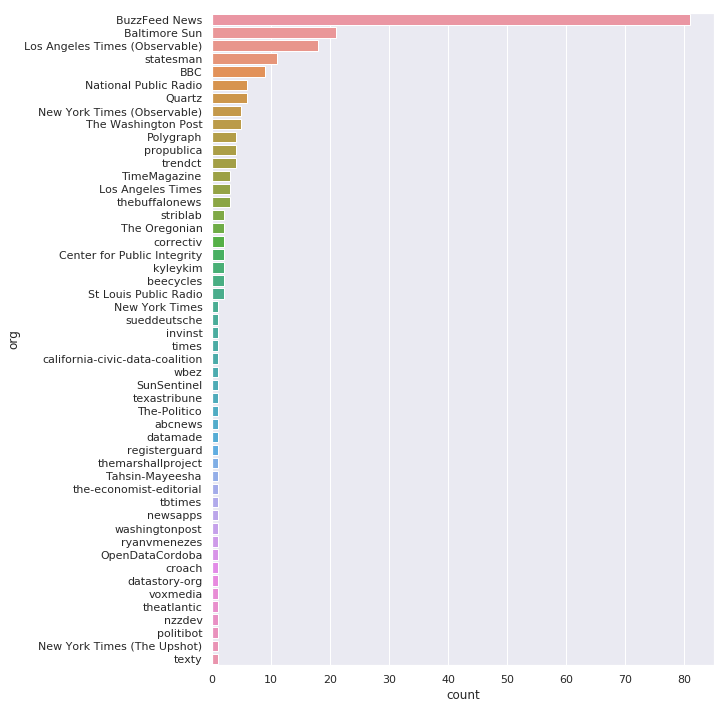

In [10]:
sns.set(rc={'figure.figsize': (9,12)})
sns.countplot(y='org', 
              data=keepers,
              order=keepers.org.value_counts().index)